In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import xgboost as xgb
print("xgb.__version__:", xgb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

xgb.__version__: 2.1.1


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

,Id,GameRulesetName,agent1,agent2,Properties,Format,Time,Discrete,Realtime,Turns,...,DoLudeme,Trigger,PlayoutsPerSecond,MovesPerSecond,EnglishRules,LudRules,num_wins_agent1,num_draws_agent1,num_losses_agent1,utility_agent1
0,0,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-ProgressiveHistory-0.6-Random200-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",4,0,11,-0.466667
1,1,00Y,MCTS-ProgressiveHistory-0.1-MAST-false,MCTS-UCB1GRAVE-0.6-NST-true,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
2,2,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.1-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",7,0,8,-0.066667
3,3,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1-0.6-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
4,4,00Y,MCTS-ProgressiveHistory-0.1-MAST-true,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,1,298.07,18877.17,Goal: Connect all three edge colors with a sin...,"(game ""00'Y'"" (players 2) (equipment { (board ...",5,0,10,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233229,233229,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-NST-false,MCTS-ProgressiveHistory-1.41421356237-Random20...,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",2,0,13,-0.733333
233230,233230,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1-0.6-MAST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",9,1,5,0.266667
233231,233231,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-false,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",11,3,1,0.666667
233232,233232,Zuz_Mel_7x7,MCTS-UCB1Tuned-1.41421356237-Random200-false,MCTS-UCB1GRAVE-1.41421356237-NST-true,1,1,1,1,0,1,...,0,0,157.52,157174.58,7x7 board. 24 pieces per player. Pieces begin ...,"(game ""Zuz Mel (7x7)"" (players 2) (equipment {...",24,2,4,0.666667


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "small"

In [4]:
# Parameters
fs_type = "fsv34"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 148
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 220
Categorical Columns: 9


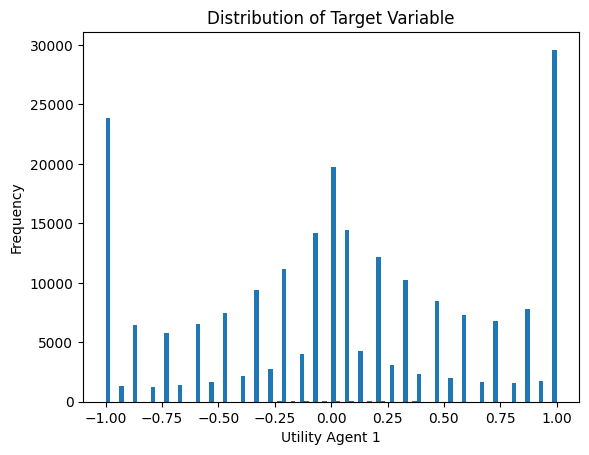

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.03
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.005
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.001
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.03 2500


In [10]:
def train_models(
        df_train,
        target,
        numerical_cols,
        categorical_cols,
        split_list=None
    ):
    # Define the parameters
    params = {
        'objective': "reg:squarederror",
        'eval_metric': 'rmse',
        'max_depth': 8,
        'max_bin': 128,
        'learning_rate': LEARNING_RATE,
        'alpha': 0.1,
        'colsample_bytree': 0.5,
        'subsample': 0.8,
        'min_child_weight': 10,
        'seed': 2112,
        'verbosity': 0,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]

        feature_types = [
            "c" if col in categorical_cols else "q" 
            for col in numerical_cols + categorical_cols
        ]
        
        # Convert to DMatrix format
        train_data = xgb.DMatrix(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )
        val_data = xgb.DMatrix(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            feature_types=feature_types,
            enable_categorical=True,
            feature_names=numerical_cols + categorical_cols
        )

        # Train the model
        model = xgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            evals=[(val_data, 'val')],
            verbose_eval=100,
        )
        
        # Get feature importance
        importance_dict = model.get_score(importance_type='gain')
        feat_importance = pd.DataFrame(
            {'feature': list(importance_dict.keys()),
             f'importance_f{fold}': list(importance_dict.values())}
        )
        feat_importance_dfs.append(feat_importance)
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(val_data)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold

        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv1.parquet', index=False)

Fold 1


[0]	val-rmse:0.55483


[100]	val-rmse:0.46742


[200]	val-rmse:0.45269


[300]	val-rmse:0.44535


[400]	val-rmse:0.43959


[500]	val-rmse:0.43692


[600]	val-rmse:0.43468


[700]	val-rmse:0.43340


[800]	val-rmse:0.43217


[900]	val-rmse:0.43146


[1000]	val-rmse:0.43075


[1100]	val-rmse:0.43033


[1200]	val-rmse:0.43005


[1300]	val-rmse:0.42991


[1400]	val-rmse:0.42970


[1500]	val-rmse:0.42947


[1600]	val-rmse:0.42947


[1700]	val-rmse:0.42953


[1800]	val-rmse:0.42956


[1900]	val-rmse:0.42964


[2000]	val-rmse:0.42964


[2100]	val-rmse:0.42975


[2200]	val-rmse:0.42983


[2300]	val-rmse:0.42985


[2400]	val-rmse:0.42994


[2499]	val-rmse:0.42993


Fold 1 - RMSE: 0.4296666562998608
Fold 2


[0]	val-rmse:0.59025


[100]	val-rmse:0.49216


[200]	val-rmse:0.47769


[300]	val-rmse:0.47090


[400]	val-rmse:0.46589


[500]	val-rmse:0.46269


[600]	val-rmse:0.46114


[700]	val-rmse:0.45954


[800]	val-rmse:0.45848


[900]	val-rmse:0.45765


[1000]	val-rmse:0.45695


[1100]	val-rmse:0.45660


[1200]	val-rmse:0.45618


[1300]	val-rmse:0.45580


[1400]	val-rmse:0.45539


[1500]	val-rmse:0.45526


[1600]	val-rmse:0.45515


[1700]	val-rmse:0.45508


[1800]	val-rmse:0.45495


[1900]	val-rmse:0.45481


[2000]	val-rmse:0.45470


[2100]	val-rmse:0.45462


[2200]	val-rmse:0.45464


[2300]	val-rmse:0.45474


[2400]	val-rmse:0.45476


[2499]	val-rmse:0.45476


Fold 2 - RMSE: 0.4542825700867805
Fold 3


[0]	val-rmse:0.60783


[100]	val-rmse:0.47605


[200]	val-rmse:0.45439


[300]	val-rmse:0.44635


[400]	val-rmse:0.44133


[500]	val-rmse:0.43840


[600]	val-rmse:0.43618


[700]	val-rmse:0.43473


[800]	val-rmse:0.43359


[900]	val-rmse:0.43266


[1000]	val-rmse:0.43193


[1100]	val-rmse:0.43132


[1200]	val-rmse:0.43080


[1300]	val-rmse:0.43061


[1400]	val-rmse:0.43048


[1500]	val-rmse:0.43022


[1600]	val-rmse:0.43015


[1700]	val-rmse:0.42994


[1800]	val-rmse:0.42977


[1900]	val-rmse:0.42962


[2000]	val-rmse:0.42957


[2100]	val-rmse:0.42944


[2200]	val-rmse:0.42933


[2300]	val-rmse:0.42917


[2400]	val-rmse:0.42916


[2499]	val-rmse:0.42911


Fold 3 - RMSE: 0.42874124106116523
Fold 4


[0]	val-rmse:0.59890


[100]	val-rmse:0.47382


[200]	val-rmse:0.45262


[300]	val-rmse:0.44345


[400]	val-rmse:0.43853


[500]	val-rmse:0.43542


[600]	val-rmse:0.43258


[700]	val-rmse:0.43090


[800]	val-rmse:0.42939


[900]	val-rmse:0.42828


[1000]	val-rmse:0.42743


[1100]	val-rmse:0.42677


[1200]	val-rmse:0.42627


[1300]	val-rmse:0.42586


[1400]	val-rmse:0.42542


[1500]	val-rmse:0.42511


[1600]	val-rmse:0.42494


[1700]	val-rmse:0.42479


[1800]	val-rmse:0.42467


[1900]	val-rmse:0.42455


[2000]	val-rmse:0.42443


[2100]	val-rmse:0.42445


[2200]	val-rmse:0.42438


[2300]	val-rmse:0.42425


[2400]	val-rmse:0.42415


[2499]	val-rmse:0.42410


Fold 4 - RMSE: 0.423744933306608
Fold 5


[0]	val-rmse:0.54953


[100]	val-rmse:0.45940


[200]	val-rmse:0.43938


[300]	val-rmse:0.43024


[400]	val-rmse:0.42470


[500]	val-rmse:0.42019


[600]	val-rmse:0.41771


[700]	val-rmse:0.41601


[800]	val-rmse:0.41426


[900]	val-rmse:0.41328


[1000]	val-rmse:0.41271


[1100]	val-rmse:0.41238


[1200]	val-rmse:0.41175


[1300]	val-rmse:0.41147


[1400]	val-rmse:0.41117


[1500]	val-rmse:0.41102


[1600]	val-rmse:0.41095


[1700]	val-rmse:0.41067


[1800]	val-rmse:0.41057


[1900]	val-rmse:0.41047


[2000]	val-rmse:0.41029


[2100]	val-rmse:0.41041


[2200]	val-rmse:0.41046


[2300]	val-rmse:0.41046


[2400]	val-rmse:0.41035


[2499]	val-rmse:0.41045


Fold 5 - RMSE: 0.41021171091691383
List of oof scores: [0.4296666562998608, 0.4542825700867805, 0.42874124106116523, 0.423744933306608, 0.41021171091691383]
Average oof score: 0.4293294223342657


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv2.parquet', index=False)

Fold 1


[0]	val-rmse:0.53665


[100]	val-rmse:0.45341


[200]	val-rmse:0.43745


[300]	val-rmse:0.43172


[400]	val-rmse:0.42754


[500]	val-rmse:0.42515


[600]	val-rmse:0.42337


[700]	val-rmse:0.42235


[800]	val-rmse:0.42134


[900]	val-rmse:0.42027


[1000]	val-rmse:0.41997


[1100]	val-rmse:0.41927


[1200]	val-rmse:0.41882


[1300]	val-rmse:0.41843


[1400]	val-rmse:0.41832


[1500]	val-rmse:0.41806


[1600]	val-rmse:0.41790


[1700]	val-rmse:0.41763


[1800]	val-rmse:0.41757


[1900]	val-rmse:0.41736


[2000]	val-rmse:0.41719


[2100]	val-rmse:0.41714


[2200]	val-rmse:0.41720


[2300]	val-rmse:0.41712


[2400]	val-rmse:0.41708


[2499]	val-rmse:0.41695


Fold 1 - RMSE: 0.41669477459162346
Fold 2


[0]	val-rmse:0.54861


[100]	val-rmse:0.43608


[200]	val-rmse:0.41857


[300]	val-rmse:0.41338


[400]	val-rmse:0.40993


[500]	val-rmse:0.40796


[600]	val-rmse:0.40688


[700]	val-rmse:0.40612


[800]	val-rmse:0.40574


[900]	val-rmse:0.40556


[1000]	val-rmse:0.40524


[1100]	val-rmse:0.40526


[1200]	val-rmse:0.40525


[1300]	val-rmse:0.40531


[1400]	val-rmse:0.40524


[1500]	val-rmse:0.40534


[1600]	val-rmse:0.40545


[1700]	val-rmse:0.40547


[1800]	val-rmse:0.40548


[1900]	val-rmse:0.40560


[2000]	val-rmse:0.40556


[2100]	val-rmse:0.40567


[2200]	val-rmse:0.40576


[2300]	val-rmse:0.40582


[2400]	val-rmse:0.40590


[2499]	val-rmse:0.40601


Fold 2 - RMSE: 0.405522762541941
Fold 3


[0]	val-rmse:0.61508


[100]	val-rmse:0.48882


[200]	val-rmse:0.46657


[300]	val-rmse:0.45652


[400]	val-rmse:0.45053


[500]	val-rmse:0.44693


[600]	val-rmse:0.44356


[700]	val-rmse:0.44191


[800]	val-rmse:0.44082


[900]	val-rmse:0.43951


[1000]	val-rmse:0.43881


[1100]	val-rmse:0.43818


[1200]	val-rmse:0.43752


[1300]	val-rmse:0.43705


[1400]	val-rmse:0.43666


[1500]	val-rmse:0.43640


[1600]	val-rmse:0.43596


[1700]	val-rmse:0.43561


[1800]	val-rmse:0.43543


[1900]	val-rmse:0.43520


[2000]	val-rmse:0.43508


[2100]	val-rmse:0.43499


[2200]	val-rmse:0.43499


[2300]	val-rmse:0.43482


[2400]	val-rmse:0.43466


[2499]	val-rmse:0.43457


Fold 3 - RMSE: 0.43424950224518105
Fold 4


[0]	val-rmse:0.60800


[100]	val-rmse:0.49028


[200]	val-rmse:0.46930


[300]	val-rmse:0.46111


[400]	val-rmse:0.45577


[500]	val-rmse:0.45243


[600]	val-rmse:0.45020


[700]	val-rmse:0.44856


[800]	val-rmse:0.44744


[900]	val-rmse:0.44674


[1000]	val-rmse:0.44630


[1100]	val-rmse:0.44567


[1200]	val-rmse:0.44513


[1300]	val-rmse:0.44475


[1400]	val-rmse:0.44451


[1500]	val-rmse:0.44445


[1600]	val-rmse:0.44430


[1700]	val-rmse:0.44399


[1800]	val-rmse:0.44395


[1900]	val-rmse:0.44373


[2000]	val-rmse:0.44373


[2100]	val-rmse:0.44378


[2200]	val-rmse:0.44379


[2300]	val-rmse:0.44380


[2400]	val-rmse:0.44368


[2499]	val-rmse:0.44371


Fold 4 - RMSE: 0.44338005899979344
Fold 5


[0]	val-rmse:0.59301


[100]	val-rmse:0.48404


[200]	val-rmse:0.46450


[300]	val-rmse:0.45453


[400]	val-rmse:0.44820


[500]	val-rmse:0.44456


[600]	val-rmse:0.44190


[700]	val-rmse:0.43979


[800]	val-rmse:0.43802


[900]	val-rmse:0.43688


[1000]	val-rmse:0.43620


[1100]	val-rmse:0.43563


[1200]	val-rmse:0.43520


[1300]	val-rmse:0.43488


[1400]	val-rmse:0.43462


[1500]	val-rmse:0.43435


[1600]	val-rmse:0.43427


[1700]	val-rmse:0.43419


[1800]	val-rmse:0.43392


[1900]	val-rmse:0.43392


[2000]	val-rmse:0.43371


[2100]	val-rmse:0.43367


[2200]	val-rmse:0.43365


[2300]	val-rmse:0.43367


[2400]	val-rmse:0.43360


[2499]	val-rmse:0.43355


Fold 5 - RMSE: 0.43316908993968456
List of oof scores: [0.41669477459162346, 0.405522762541941, 0.43424950224518105, 0.44338005899979344, 0.43316908993968456]
Average oof score: 0.4266032376636447


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    'utility_agent1',
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_xgboost_{fs_type}_cv3.parquet', index=False)

Fold 1


[0]	val-rmse:0.57736


[100]	val-rmse:0.47252


[200]	val-rmse:0.45347


[300]	val-rmse:0.44569


[400]	val-rmse:0.44128


[500]	val-rmse:0.43873


[600]	val-rmse:0.43709


[700]	val-rmse:0.43586


[800]	val-rmse:0.43508


[900]	val-rmse:0.43444


[1000]	val-rmse:0.43361


[1100]	val-rmse:0.43306


[1200]	val-rmse:0.43289


[1300]	val-rmse:0.43279


[1400]	val-rmse:0.43277


[1500]	val-rmse:0.43289


[1600]	val-rmse:0.43288


[1700]	val-rmse:0.43275


[1800]	val-rmse:0.43266


[1900]	val-rmse:0.43269


[2000]	val-rmse:0.43266


[2100]	val-rmse:0.43274


[2200]	val-rmse:0.43267


[2300]	val-rmse:0.43276


[2400]	val-rmse:0.43287


[2499]	val-rmse:0.43299


Fold 1 - RMSE: 0.4326817169983959
Fold 2


[0]	val-rmse:0.57589


[100]	val-rmse:0.47077


[200]	val-rmse:0.45139


[300]	val-rmse:0.44225


[400]	val-rmse:0.43577


[500]	val-rmse:0.43154


[600]	val-rmse:0.42872


[700]	val-rmse:0.42689


[800]	val-rmse:0.42549


[900]	val-rmse:0.42426


[1000]	val-rmse:0.42331


[1100]	val-rmse:0.42281


[1200]	val-rmse:0.42231


[1300]	val-rmse:0.42180


[1400]	val-rmse:0.42150


[1500]	val-rmse:0.42120


[1600]	val-rmse:0.42092


[1700]	val-rmse:0.42083


[1800]	val-rmse:0.42056


[1900]	val-rmse:0.42041


[2000]	val-rmse:0.42048


[2100]	val-rmse:0.42032


[2200]	val-rmse:0.42021


[2300]	val-rmse:0.42020


[2400]	val-rmse:0.42013


[2499]	val-rmse:0.42004


Fold 2 - RMSE: 0.4197132185631509
Fold 3


[0]	val-rmse:0.57907


[100]	val-rmse:0.46869


[200]	val-rmse:0.45174


[300]	val-rmse:0.44379


[400]	val-rmse:0.43863


[500]	val-rmse:0.43559


[600]	val-rmse:0.43357


[700]	val-rmse:0.43214


[800]	val-rmse:0.43062


[900]	val-rmse:0.42972


[1000]	val-rmse:0.42896


[1100]	val-rmse:0.42836


[1200]	val-rmse:0.42805


[1300]	val-rmse:0.42765


[1400]	val-rmse:0.42729


[1500]	val-rmse:0.42711


[1600]	val-rmse:0.42694


[1700]	val-rmse:0.42673


[1800]	val-rmse:0.42663


[1900]	val-rmse:0.42650


[2000]	val-rmse:0.42633


[2100]	val-rmse:0.42630


[2200]	val-rmse:0.42620


[2300]	val-rmse:0.42622


[2400]	val-rmse:0.42618


[2499]	val-rmse:0.42625


Fold 3 - RMSE: 0.42602315914280736
Fold 4


[0]	val-rmse:0.57737


[100]	val-rmse:0.46364


[200]	val-rmse:0.44382


[300]	val-rmse:0.43684


[400]	val-rmse:0.43159


[500]	val-rmse:0.42877


[600]	val-rmse:0.42696


[700]	val-rmse:0.42570


[800]	val-rmse:0.42480


[900]	val-rmse:0.42438


[1000]	val-rmse:0.42382


[1100]	val-rmse:0.42340


[1200]	val-rmse:0.42310


[1300]	val-rmse:0.42291


[1400]	val-rmse:0.42278


[1500]	val-rmse:0.42270


[1600]	val-rmse:0.42261


[1700]	val-rmse:0.42255


[1800]	val-rmse:0.42248


[1900]	val-rmse:0.42241


[2000]	val-rmse:0.42229


[2100]	val-rmse:0.42230


[2200]	val-rmse:0.42219


[2300]	val-rmse:0.42205


[2400]	val-rmse:0.42212


[2499]	val-rmse:0.42211


Fold 4 - RMSE: 0.42185565654881135
Fold 5


[0]	val-rmse:0.58793


[100]	val-rmse:0.47978


[200]	val-rmse:0.45816


[300]	val-rmse:0.44923


[400]	val-rmse:0.44287


[500]	val-rmse:0.43951


[600]	val-rmse:0.43710


[700]	val-rmse:0.43524


[800]	val-rmse:0.43385


[900]	val-rmse:0.43258


[1000]	val-rmse:0.43181


[1100]	val-rmse:0.43108


[1200]	val-rmse:0.43031


[1300]	val-rmse:0.42980


[1400]	val-rmse:0.42940


[1500]	val-rmse:0.42915


[1600]	val-rmse:0.42902


[1700]	val-rmse:0.42881


[1800]	val-rmse:0.42859


[1900]	val-rmse:0.42848


[2000]	val-rmse:0.42841


[2100]	val-rmse:0.42839


[2200]	val-rmse:0.42821


[2300]	val-rmse:0.42819


[2400]	val-rmse:0.42809


[2499]	val-rmse:0.42796


Fold 5 - RMSE: 0.4277363228808277
List of oof scores: [0.4326817169983959, 0.4197132185631509, 0.42602315914280736, 0.42185565654881135, 0.4277363228808277]
Average oof score: 0.42560201482679866


In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4297
Score: 0.4543
Score: 0.4287
Score: 0.4237
Score: 0.4102
Average CV1 Score: 0.4293

CV2 OOF Scores:
Score: 0.4167
Score: 0.4055
Score: 0.4342
Score: 0.4434
Score: 0.4332
Average CV2 Score: 0.4266

CV3 OOF Scores:
Score: 0.4327
Score: 0.4197
Score: 0.4260
Score: 0.4219
Score: 0.4277
Average CV3 Score: 0.4256


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

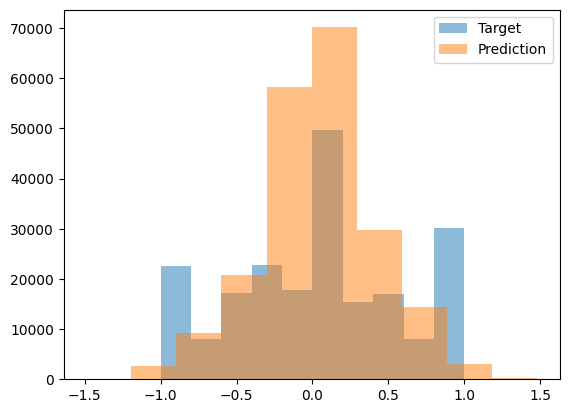

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Create feature types list for XGBoost
    feature_types = [
        "c" if col in categorical_cols else "q" 
        for col in numerical_cols + categorical_cols
    ]

    # Create XGBoost DMatrix for test data
    test_dmatrix = xgb.DMatrix(
        data=test_processed[numerical_cols + categorical_cols],
        feature_types=feature_types,
        enable_categorical=True
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_dmatrix)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [20]:
# Save all artifacts needed for prediction
xgboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./xgboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(xgboost_predict, f)

***